In [79]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
df_train = pd.read_csv(train_csv_path, sep=",")
df_train["img_path"] =  df_train['image_id'].apply(build_image_path, convert_dtype=str)

df_test = pd.read_csv(test_csv_path, sep=",")
df_test["img_path"] =  df_test['image_id'].apply(build_image_path, convert_dtype=str)

In [81]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de teste: ", df_test.shape[0])
print("Distribuição de cancer no conjunto de teste: ", df_test.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

Número de imagens no conjunto de treinamento:  34995
Distribuição de cancer conjunto de treinamento:     cancer   qtde
0       0  34222
1       1    773
Número de imagens no conjunto de validação:  8749
Distribuição de cancer no conjunto de validação:     cancer  qtde
0       0  8556
1       1   193
Número de imagens no conjunto de teste:  10962
Distribuição de cancer no conjunto de teste:     cancer   qtde
0       0  10770
1       1    192


In [82]:
# Nesse momento, vou aplicar o undersampling escolhendo aleatoriamente 900 imagens sem cancer no conjunto de treinamento. 
df_train_split = pd.concat([df_train_split[df_train_split["cancer"]==1], df_train_split[df_train_split["cancer"]==0].sample(n=900)])
df_train_split = df_train_split.sample(n=df_train_split.shape[0])
print(df_train_split.groupby("cancer").agg(qtde=("cancer","count")).reset_index())

   cancer  qtde
0       0   900
1       1   773


In [83]:
# # Já para validação, vou escolher 230 imagens seguindo a mesma ideia.
df_val_split = pd.concat([df_val_split[df_val_split["cancer"]==1], df_val_split[df_val_split["cancer"]==0].sample(n=230)])
df_val_split = df_val_split.sample(n=df_val_split.shape[0])
print(df_val_split.groupby("cancer").agg(qtde=("cancer","count")).reset_index())

   cancer  qtde
0       0   230
1       1   193


In [84]:
clean_all_datasets()

# Criando os diretórios:
create_dataset_dirs()
    
# Criando os subdiretórios
build_train_dataset_from_ori_imgs(df_train_split)
    
build_val_dataset_from_ori_imgs(df_val_split)

build_test_dataset_from_ori_imgs(df_test)

In [85]:

def preprocess_dataset(dataset):
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  # dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
  return dataset

train_dataset = image_dataset_from_directory(
    directory=train_dir_path,
    image_size = (img_height, img_width),
    batch_size = 64,
    label_mode = 'binary')

class_names = train_dataset.class_names

transf_train_dataset = preprocess_dataset(train_dataset)

validation_dataset = image_dataset_from_directory(
        directory=val_dir_path,
        image_size = (img_height, img_width),
        batch_size = 64,
        label_mode = 'binary')

transf_validation_dataset = preprocess_dataset(validation_dataset)

test_dataset = image_dataset_from_directory(
        directory=test_dir_path,
        image_size = (img_height, img_width),
        batch_size = 128,
        label_mode = 'binary')

transf_test_dataset = preprocess_dataset(test_dataset)

Found 1673 files belonging to 2 classes.
Found 423 files belonging to 2 classes.
Found 10962 files belonging to 2 classes.


2023-06-24 11:19:31.048020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1673]
	 [[{{node Placeholder/_0}}]]
2023-06-24 11:19:31.048491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1673]
	 [[{{node Placeholder/_0}}]]


Image props -> Shape: (512, 256, 3), MaxVal: 0.9960784912109375, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.9960784912109375, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.9921569228172302, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.960784375667572, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.988235354423523, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.7921569347381592, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.9960784912109375, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.7882353663444519, MinVal: 0.0, Type: float32
Image props -> Shape: (512, 256, 3), MaxVal: 0.9960784912109375, MinVal: 0.0, Type: float32


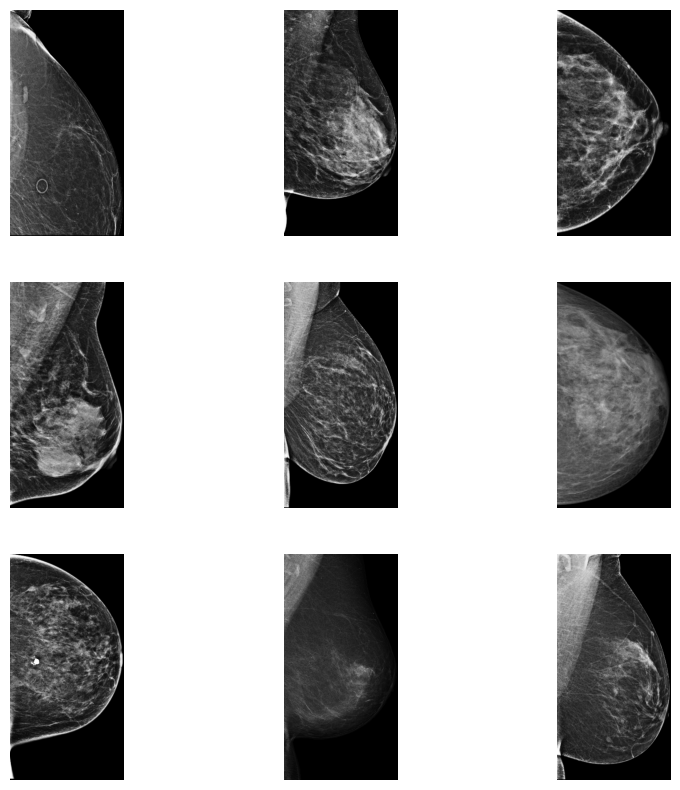

In [86]:
def plot_images(dataset):
  # class_names = dataset.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
    for i in range(9):
      image = images[i].numpy()
      print_img_props(image)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image, cmap='gray')
      # plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
      plt.axis("off")
    
plot_images(transf_train_dataset)

In [87]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

model_resnet50 = ResNet50V2(weights = 'imagenet', input_shape = (img_height, img_width, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
# build the entire model
x = model_resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [89]:
from keras.optimizers import SGD, Adam

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'resnet50_undersampling.h5', monitor = "val_loss", mode = "min", save_best_only = True)

# define training function
def trainModel(model, epochs, optimizer, callbacks = []):
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(transf_train_dataset, validation_data=transf_validation_dataset, epochs=epochs, callbacks=callbacks)

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam =  Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_history = trainModel(model = model, epochs = 10, optimizer = sgd, callbacks = [early_stopper, save_model])

Epoch 1/10
27/27 [==============================] - 14s 432ms/step - loss: 0.6964 - accuracy: 0.5176 - val_loss: 0.6926 - val_accuracy: 0.5366
Epoch 2/10
27/27 [==============================] - 11s 403ms/step - loss: 0.7024 - accuracy: 0.5117 - val_loss: 0.6921 - val_accuracy: 0.5437
Epoch 3/10
27/27 [==============================] - 11s 405ms/step - loss: 0.6989 - accuracy: 0.5027 - val_loss: 0.6917 - val_accuracy: 0.5437
Epoch 4/10
27/27 [==============================] - 11s 401ms/step - loss: 0.6992 - accuracy: 0.5015 - val_loss: 0.6916 - val_accuracy: 0.5437
Epoch 5/10
27/27 [==============================] - 11s 386ms/step - loss: 0.6981 - accuracy: 0.5021 - val_loss: 0.6917 - val_accuracy: 0.5437
Epoch 6/10
27/27 [==============================] - 11s 388ms/step - loss: 0.6993 - accuracy: 0.4997 - val_loss: 0.6921 - val_accuracy: 0.5437
Epoch 7/10
27/27 [==============================] - 11s 392ms/step - loss: 0.6995 - accuracy: 0.5075 - val_loss: 0.6923 - val_accuracy: 0.5437

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'loss')

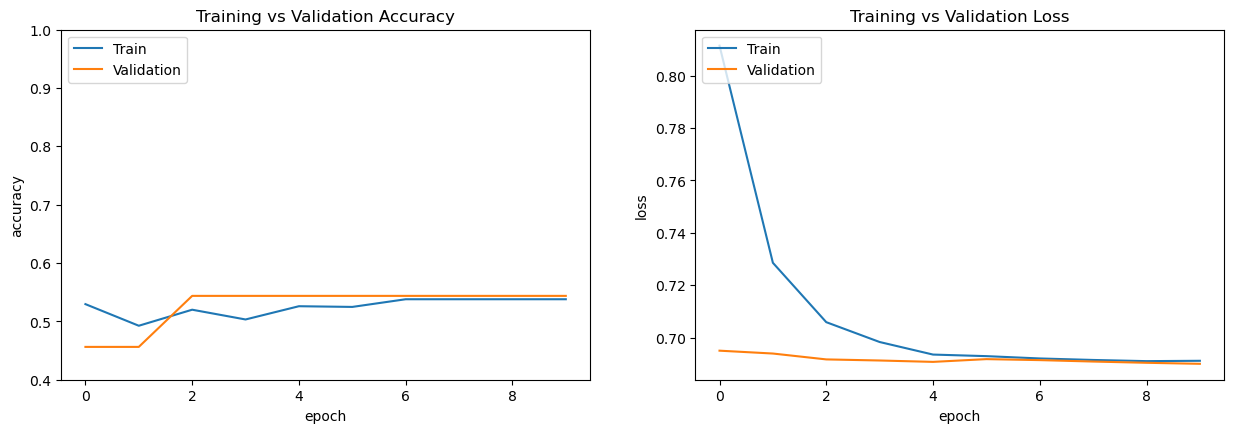

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
model_resnet50 = load_model('resnet50_undersampling.h5')

pred_resnet50 = model_resnet50.predict(transf_test_dataset)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        


2023-06-24 10:54:04.640427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10962]
	 [[{{node Placeholder/_4}}]]
2023-06-24 10:54:04.640601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10962]
	 [[{{node Placeholder/_0}}]]


172/172 [==============================] - 52s 302ms/step


Text(50.722222222222214, 0.5, 'Real')

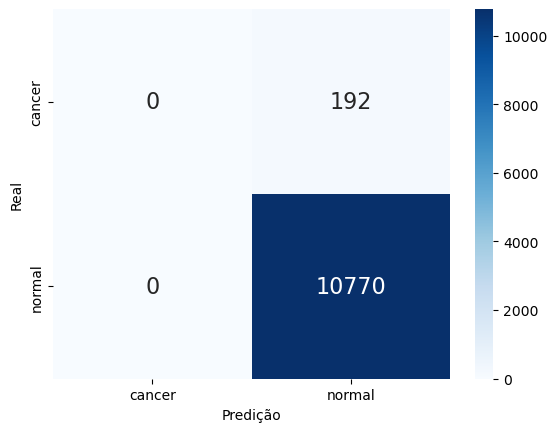

In [ ]:
# Extract the labels from the dataset
labels = np.concatenate([y for _, y in test_dataset], axis=0)

cm = confusion_matrix(labels, y_pred_resnet50)

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")